In [1]:
import csv
import math
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import gzip
import pickle
import decimal

In [2]:
lineNames = ["SC05","A900","A975","A976", "PO88"]

scaffNames = ["scaffold_6540","scaffold_6500","scaffold_6680","scaffold_6496",
              "scaffold_6473","scaffold_6328","scaffold_6308","scaffold_6359"]

scaffSizes = [34148556,32352404,24764193,26866924,
              16943266,4453435,3356042,4525533]

bedFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/gimble.mainScaffs.bed"
genotypesFile = '/home/miguel/Desktop/HonoursProject/Data/forMiguel/inbredGenotypes.txt'
dataSaveFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/scaffGenotypeDict"

In [3]:
scaffIndexDict={a:b for (a,b) in  list(zip(scaffNames,range(len(scaffNames))))}
strainIndexDict={a:b for (a,b) in  list(zip(lineNames,range(len(lineNames))))}

In [4]:
def check_genotypes(gl):
    ggl = [x.strip().split("/" or "|") for x in gl]
    ggl = [ 1 if (('.' in x) or (len(x)<2)) else (1 if x[0]==x[1] else 2) for x in ggl ]
    return(ggl)

def count_sites(arr): #this is an array of positions for a particular strain
    (unique,counts) = np.unique(arr,return_counts=True)
    zeros = 0
    ones = 0
    twos = 0
    for xl in list(zip(unique,counts)):
        if xl[0] == 0:
            zeros = xl[1]
        if xl[0] == 1:
            ones = xl[1]
        if xl[0] == 2:
            twos = xl[1]
    return([zeros,ones,twos])

def calc_diversity(winArr): # a window of sites, each has the genotypes
    countsByStrain = [count_sites(x) for x in winArr.transpose()] #transpose to get strain-wise site list
    divByStrain = [0 if (x[1]+x[2])==0 else 1.0/2*x[2]/(x[1]+x[2]) for x in countsByStrain]
    return(divByStrain)

In [5]:

with gzip.open(dataSaveFile,mode="rb") as infile:
    scaffGenotypeDict = pickle.load(infile)

In [63]:
testchr = scaffGenotypeDict['scaffold_6496'];
chrName = 'Chr2'
chunkSize = 50000
windowWidth = 3 #as a number of chunks per window

stride = 1  #should probably keep as 1
numChunks = int(len(testchr)/chunkSize)
chunks = np.array_split(testchr,numChunks);
chunkSizeTrue = len(chunks[1])
divCalc = [calc_diversity(x) for x in chunks]
divCalc = np.asarray(divCalc)
#returns list of windows, each window a list of per-strain results. 
#take the transpose to get each strain as a list of the windows
allcounts = [[count_sites(y) for y in x.transpose()] for x in chunks]
coverage = [(chunkSizeTrue-x[0])/chunkSizeTrue for x in [y[0]for y in allcounts]]

In [ ]:
thisStrainIdx = 4
print("strain:  "+lineNames[thisStrainIdx])
x = np.arange(0, 34100000, 50000)

plt.style.use("seaborn-paper")
plt.rcParams.update({'figure.autolayout': True})
plt.plot(x,coverage,'m',linewidth = 1.5)
plt.ylim([0,1])
#plt.savefig('/home/miguel/Desktop/Pretty_figures/coverageChr2.png')
plt.show()

len(coverage)

In [76]:
thisStrainIdx = 3
divCalcByStrain = divCalc.transpose()

windows = [] 
for x in range(0,numChunks-(windowWidth-stride),stride):
    windows.append([x,x+windowWidth])

res = [   [[] for x in range(numChunks)] for y in range(len(lineNames)) ]
for strainIdx in range(len(lineNames)):    
    for [l,r] in windows: 
        thisWinDiv = divCalcByStrain[strainIdx][l:r]
        total = sum(thisWinDiv)
        mean = total/len(thisWinDiv) 
        for x in range(l,r,1):
            res[strainIdx][x].append(mean)
            
overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
overlapingDivCalcByStrain = np.asanyarray(overlapingDivCalcByStrain)
overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]

In [77]:
threshold = 0.0015
hetero_or_not =[]
for chunk in overlapingDivCalcByStrain[thisStrainIdx]:
    if chunk >= threshold:
        hetero_or_not.append(0.0015)
    else:
        hetero_or_not.append(0)
len(hetero_or_not)

537

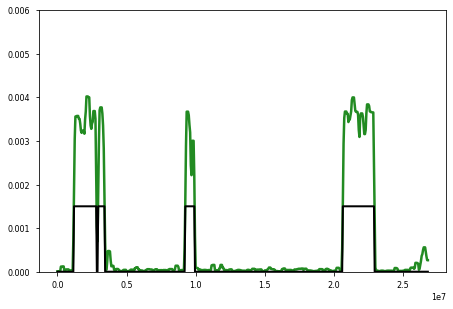

In [78]:
x = np.arange(0, 26850000, 50000)
plt.plot(x,overlapingDivCalcByStrain[thisStrainIdx],color = 'forestgreen',linewidth = 2.5)
axes = plt.gca()
axes.set_ylim([0,0.006])
plt.plot(x,hetero_or_not,color = 'k',linewidth = 2)
plt.savefig('/home/miguel/Desktop/Pretty_figures/tractsChr5A976.png')
plt.show()

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcUAAAE1CAYAAACWU/udAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nO3deZgcdZ0/8Penp+fOnMnAJEAgmBACAUIIcgZcCSCwkBUV5VgeFRdEdkUXfuoKu7gbUWGVPLAiyKNy6AouKLCosBhCzEESSAgBcpOEJOScZDIzmckcfXx/f3RVzbe6q7tqqqu653i/eHhSXdVHTXV1fb6f71WilAIREREBkWLvABER0WDBoEhERGRgUCQiIjIwKBIRERkYFImIiAwMikRERAZPQVFE5orIIhF5MG39VBFZLCJLROTUHOsaReR/RGS+iNwV/J9BRESUv6jbE0RkOoBqpdRMEXlERM5USr1lbJ4D4FoASQA/AzA7y7p7APybUmp9CH8DERFRILxkiucAmGcszwNwtratUSm1Qym1E0BdjnVTAXxXRF4XkXOC2HEiIqKguWaKAOoBbDaW2wGcrG2LOCw7rTsXwHQArQB+D+D8bB8mIjcDuBkAqqurzzjxxBM97CIREZE3K1eu3K+UanLa5iUotgGoNZZrjcempMOy07qNSql1ACAi+vYMSqnHADwGADNmzFArVqzwsItERETeiMi2bNu8VJ8uBXCRsTwLwDJtW6uIHC0i45DKIrOt2ygiY0WkGt4CMRERUcG5Biil1Nsi0iMiiwCsBrBdRO5SSt2LVAeaZwAIgNuMl2Rb9zSASgD/HuyfQEREFAwZzHfJYPUpEREFTURWKqVmOG3j4H0iIiIDgyIREZGBQZGIiMjAoEhERGRgUCQiIjIwKBIRERkYFImIiAwMikRERAYGRSIiIgODIhERkYFBkYiIyMCgSEREZGBQJCIiMjAoEhERGRgUiYiIDAyKREREBgZFIiIiA4MiERGRgUGRiIjIwKBIRERkYFAkIiIyMCgSEREZGBSJiIgMDIpEREQGBkUiIiIDgyIREZGBQZGIiMjAoEhERGRgUCQiIjIwKBIRERkYFImIiAwMikRERAYGRSIiIgODIhERkYFBkYiIyMCgSEREZPAUFEVkrogsEpEH09ZPFZHFIrJERE7Nse4JEVkuIgtE5Lrg/wwiIqL8Rd2eICLTAVQrpWaKyCMicqZS6i1j8xwA1wJIAvgZgNlZ1gHA9UqpD4L+A4iIiILiJVM8B8A8Y3kegLO1bY1KqR1KqZ0A6nKsUwCeEpGXROTYIHaciIgoaF6CYj2ADmO5HUBDltdHcqy7Qyl1LoD7APwk14eJyM0iskJEVrS0tHjYPSIiomB4CYptAGqN5VrjsSnpsJyxTinVavy7GEBzrg9TSj2mlJqhlJrR1NTkYfeIiIiC4SUoLgVwkbE8C8AybVuriBwtIuOQyiId14lIrfHvZNiDKhER0aDh2tFGKfW2iPSIyCIAqwFsF5G7lFL3ArgHwDMABMBtxkuc1v23iDQg1bZ4a8B/AxERUSBEKVXsfchqxowZasWKFcXeDSIiGkZEZKVSaobTNg7eJyIiMjAoEhERGRgUiYiIDAyKREREBgZFIiIiA4MiERGRgUGRiIjIwKBIRERkYFAkIiIyMCgSEREZGBSJiIgMDIpEREQGBkUiIiIDgyIREZGBQZGIiMjAoEhERGRgUCQiIjIwKBIRERkYFImIiAwMikRERAYGRSIiIgODIhERkYFBkYiIyMCgSEREZGBQJCIiMjAoEhERGRgUiYiIDAyKREREBgZFIiIiA4MiERGRgUGRiIjIwKBIRERkYFAkIiIyMCgSEREZGBSJiIgMnoKiiMwVkUUi8mDa+qkislhElojIqdnWGesrRWSPiMwK9k8gIiIKhmtQFJHpAKqVUjMBlInImdrmOQCuBXCNsZxtHQDcDOD9IHZ6sFu2fRmu/931uPo3V+P+hfcjqZLF3iUiIvIg6uE55wCYZyzPA3A2gLeMx41KqR0AICJ12daJSBmAswAsDmi/B7WH3ngIyz9aDgBYvWc1Xlj7Ap75wjMYXz++yHtGRIPFio9W4EcLf4TDfYdx7rHn4q5P3AURKfZujXheqk/rAXQYy+0AGrK8PpJj3ZcA/NrLDonIzSKyQkRWtLS0eHnJoNPa3Wp7vLdzL/64/o9F2hsiGox+vPjHWLVrFTbs34DHVz6Ojfs3FnuXCN6CYhuAWmO51nhsSjos29aJSBTApUqpl73skFLqMaXUDKXUjKamJi8vGXQOxw4DAM446gxrXWdfZ7F2h4gGmcN9h7Fq1yrbul0du4q0N6TzEhSXArjIWJ4FYJm2rVVEjhaRcUhlkU7rjgRwjIi8AuAGAD8UET3bHHbMoDilaQpqymsAAN2x7mLuEhENIit2rkA8Gbet29O5p0h7QzrXNkWl1Nsi0iMiiwCsBrBdRO5SSt0L4B4AzwAQALcZL7GtU0rtBHAmAIjI9wAsVkodDPwvGUS6+roAAFWlVaiMVuJQ7yH0xHuKvFdENFh8ePDDjHX7OvcVfkcog5eONlBK3Z626l5j/bsAzk97bsY6bdv3Br6LQ0ssEUNfog9AKihWRCsAgEGRiCwdvR3Wcm15LTp6O5gpDhIcvB8wvZq0qqwKFaUMikRkd6j3EACgIlqBY+qOAcBMcbBgUAyY2Z4I2DNFtikSkcnMFGvKa3DEqCMApHqpe6GUwt1/uRuzfjkLVz11FZZsWxLafo5EDIoB04NidVk1KqOVAIDeeG+xdomIBhkzU6wtr8WRo44E4D0orm9Zj6dXP42tB7dizb41+N5r3+MEIQFiUAyY2ckGSGWK5dFyAMwUiaifU1Bs7W71VHhu6bKP397SugVLty8NfidHKAbFgNmqT8uqUFmayhS9tCn+etWv8anHP4XLn7gcv3v3d6HtIxEVl1l9Oqp8lBUUAWB/137X1x7szuy8v2bvmuB2boRjUAzY4T7nNkW3EmB3rBs/WPADbDqwCRv2b8B9C+8LdT+JqHjMoFhbXmu1KQLA3i73KtT0GbMA4KP2j4LbuRGOQTFgGR1tjN6n3fHc1afv7nnXGsoBAO097VYVCxENLx09RlCsqEXzqGZr/d5D7kGxrTs1qZhAMHnMZADARx0MikFhUAyYraNNaXXGOEWlFDbu34i1+9baZrR466O3kG73od0h7y0RFZpSypr2saasZsCZoll9Wl9Zb91kgJlicDwN3ifvumJaR5uyKqv3aU8sFRS//cq38fs1vwcAnD7udDx77bMQEWxu3ZzxXrsP7cYJY04owF4Pb+097Xjy7SfR0tWCiaMn4sbTb+TdCCh0SZXEA4sfwIaWDairqMOdM+9Ec00zeuO9Vq1QbUUtGisbUVZShr5EHx564yHUlNXgshMuQ1VZleP7mkGxobIBR9cdDQDY3LoZr256FZdMuqQwf9wwxqAYsM7e/om/9TbFWDKGeDKORR8usrav2rUKnX2dqCmvQV+8fxYcM9tkphiMX6/6NR58o//+2BMaJuCCCRcUcY9oJFiybQkeWf6I9bgkUoL7PnUf9h/u70xTV1EHEcEFx12AeZvnob2nHd965VvYdGATvnPhdxzf12xTrK+ox8caP2atv/XFW9FU3YQTxpyAey++F8fUHxPSXza8sfo0YOYJO6psFMqj5VabIpCqQm3vbbc93+xtFkvGAABH1R4FQSqL2d3BoBiE9JlCVu5cWaQ9oZEkfX7T595/Duv2rcOm/ZusdWZQ+96s72FczThr/YItC9DR04FbX7wVf/vk3+Km399kDcVo60m1KTZWNmL2lNmYPWW29bqWrhYs2bYEf1jzh5D+quGPQTFgBw4fAAA0VjUCgFV9CqQa19N7oZrPjyVSQbGqtApjqscA8D6Yl3IzCxymNfvYfZ3C5/T7/dLvv2S7b+Kk0ZMAAGNrxmLBPyzAjaffCADYdGATnlz1JF7d9CrWtazDgq0L8JtVvwHQHxTrKupQVVaFB654AE9//ml87eyvWe+rN+PQwDAoDoBSCu/sfgevbHwF7+5+1/E5ZpAbXTUaAKzqUwDY15U5t6EVFI0Ld7QkivqKegD2SYPJP7PAYXp/7/tF2hMaSczmD/P3DKQyuff3pc6/MVVjrMIzkKpevehjF1mPn1/zvO39Vu9ZDaB/IhC9zfHjx3wcd5x/B0aVjQIAznCTB7YperT4w8WYM38OPmj9wFr3q8/8ChdOuND2vIygqFWfOnW3NtsXzJ6o0UgUo8pTJzaHZAQj/b51LV0t6In12L4boqCZmeKExgm4+uSr8a9/+VcAwPIdywHAsRPdUXVHWcvb2rbZtr235z0opfqDYmlmR5ySSAkAIJFMBPAXjEzMFD26f9H9toAIAK9uejXjea2HU22KjZWpEqBZcgOAnR07M56fXn1aVlKGmrLUjYkZFIORHhSB/iooorDsOZS6FVTzqGarkAz0/+YnjZmU8Zrq0uqs79fW04bt7dutnqvmbFm6EmFQzBeDokft3f0dZEojpQCAZ959Bu09/euTKml1tDF/BPWV/VUn29u2Z7xvekebaCSKmnIjKPYxKAYhvU0RgO17IwqDFRRrmjG6cnTGdrM9Uec0DEN/nt55R++vYLIyRcWg6BeDoke9iVQHmc+f+nlbg/adf77TWm7rbrPq8s2gWFdRZ21Prw4BtOrTRCqbKS0p7Q+KzBQDkd6mCDjPH0kUlEQyYc1iVVdeZ2s7NDlVnzoFulOaT7GW9domx+pTZop5Y1D0yOw1Wl5SjiunXGmtf2f3O9ayfqE1q0/1RvYd7Tus5bE1YwH0N5o7ZooMioEwq0/1Tk/MFClM+pSNZSVltupTk1OmWBIpsZ2nAKxZawBgV8cua9mp+jQiqUs6M0X/GBQ9Mk/y8mg5JjRMwNfP+TqA1LhEM3iZUzcBsAJbbXmtNe5Qrz41g6aZWZqZYllJmfXavkQf78MYAPPYNlU3WevYpkhhsgXFaBlqy2tt278y4yuorahNfxmAzAzwqNr+zjf6dG5OQTEaSfWdZO9T/xgUPVBK2TJFAJg4eqK13Qx2+tig6rJUg3lJpMQ6+c3Smz6o38xi+pKpH1E0ErU62gD2QEv+mFn4mKox1jpzUmWiMKRniunTCv7LJ/4l62vTg2JDZYN1X1a9+tQxU4ykLulOncvIGwZFD2LJGBQUgFSpDwCObTjW2m62FabfYNiktysCwGnNpyEq9hKdU5siwCrUIJgXiJryGpSVpL4/ZooUJnPaRgDWOXfppEsBAN847xs5X5ve2aYyWmnVLOnVp05titZ1JclM0S8GRQ/0KkwzUzy2vj8ompmifi9FfSiG3q4IAJ875XNWic7MHp3aFAEGxSCYQbG0pNQqoDAoUpjSM0UAmHvFXDx/w/O49axbc742fVhGRWmFFRT3dO6x1ufMFBUzRb8YFD2wBUWjGqOmvMYKXmbX6/Q7ZJjSg+IZR51h9RIzS3RWm2KkzB4UOSwjb2bv09JIqfVdMChSmJyCYnm0HKc2n2q1+2WTHuwqo5WOvVedeqpabYrMFH1jUPRAP8HNoAgAR1YfCaD/Hmh69anZpgik2gRMEYlgXM04azyRmcXo07zpWaZ+1w3yRz+25sXFHEBNFAZzCBfQ3+TiVXr1aUVphe0aYsrV+5Rtiv4xKHqgn+Bm9SkANI1K9WZs6UzNXq9Xn+r1/fp4pNKSUpSWlPZniioJpZQtm9EDr/7Z5I+ZhUcjUasHqnnHAaIwOGWKXmVUn0adg2LOcYockuEb5z71QG80t2WKo4xMsdOeKVaVVlklNgA4bexp1rJZFau3KSZUwurIEy2J2gKv/tnkj9WmqFWfHuhipkjhyScoOlafVjpUnzpN8xbpL2yTP8wUPXDqaAMAR1QfASCVdSilrDbF9BKcPiNF86hmAP29xBLJhJXJAMwUw6BXn5qZYlesy5bZEwVJL8yWlpQO6LW5OtqYIhJxDLbpzTI0cAyKHmRrHzhiVCooxpIxfOUPX8Ez7z4DwN6eCKR6on7m5M+gIlqBH33qRwDsmaI+N2dpSVpQ5OD9vOlV0/pYRf0O6ERByidTTG9TLI2UZnS0qSqtyhj7CMDWLEP+MCh64JYpAsCCrQus5fRpmgDg/svux6p/WoWZx80EYJ+jUJ+bMxqJ2n5ErD7Nn159at7AGWC7IoVH/00PNCimj2sWkYw2RbNAno6ZYv4YFD3IlimePu50x+c73SIKsP849PuepWeKtqCYYFDMl3WvSq36FGCmSOHJJ1PUC9um9KDoNG8qgIyhXjRwDIoeZMsUx9WOc3y+l6nZ9F5i6W2KJZES6/ZUbFPMn1lqj0aitosLp3qjsOQVFB2ywPQ2RX2aSZ2VKXLwvm8Mih5kG6cIAD+98qcAgGtPu9Zal1794UTvJWbOewr0N8qbPyS2KeYnkezv2VsasWfhTreUIgpCPkFRr80w6fdlBXIERWaKeeOQDA+cZrQxXTb5MqyfuB7RSBQTGibg8ZWP4weX/MD1PfVBtnqmaM5IUR4tR1esi0ExT3rgM8eIWtscbj5MFIRcBWk3TtWn0UgUpxx5Ct7b+x7KSsow46gZjq/lTYbzx6DogR6YnEp95oX2phk34aYZN3l6T/0WL3qjuJUpGm2XbFPMjx74opGobYotdkagsATZ+9T01OeewtIdS3HCmBOyNt3wJsP5Y1D0wDajzQBLfdlYNwNN631qtiWabZdsU8yPHviiJfagyOpTCks+4xSzqa2ote60kQ0zxfyxTdGDbB1t8qG3Kab3PgXYphgUWxYesVefMlOksJiZYmmk1Da7lVdfPuPLAIBvzfzWgF6n92onfzx9WyIyV0QWiciDaeunishiEVkiIqfmWPegiPxVRJaLyHnB/xnhMrO1iERcZ7j3yqzmiCfjGeMUgf6MlNWn+Uk/thGJWMeebYoUFvN3O9CqU9N3P/FdvPHVN3DLWbcM6HV6DRT54xoURWQ6gGql1EwAZSJyprZ5DoBrAVxjLGdbd6dS6kJj3XcD2veC0SeUdppFwg89U3RqUzSDIjPF/NiqT40CR7Qk9e+Glg34xVu/wJNvP8mB/BQoKygO8A4ZJhGx5lYeCL2vAvnjJe05B8A8Y3kegLMBvGU8blRK7QAAEanLtk4pZRbJRwFYHcB+F5RZ6goqSwTc2xSt6lO2KeYlvfcpkDrGvejFa5tfw2ubXwMAvL7ldTzx2SeKsYs0DOnVp4XEW0flz0v1aT2ADmO5HYA+tULEYdlpHUTkeQCvoj/AOhKRm0VkhYisaGkZHKV3s9HazO6CYAbYhErYxila1aclzBSDkN6mCDh3fNjWtq1g+0TDX77Vp34xU8yfl6DYBqDWWK41HpuSDstO66CU+jRSWWbOQXxKqceUUjOUUjOamjIHsRaDmSmabVFB0N9Lbzdkm2KwbEMyjGpTp4xfHytKlC+z96nf6lO/mCnmz0tQXArgImN5FoBl2rZWETlaRMYhlUU6rhMRs8vmIQBdGGLMKZOCzBTNu2QA9myQbYrBcmpTdKrS4kWEgmTW/jBTHHpcG8mUUm+LSI+ILEKqPXC7iNyllLoXwD0AngEgAG4zXuK07ndG+2IUwL8E/DeELoxM0byfImDPBs3AyzbFYKTPKwv0Z4y25zEoUoCsa0aABWkvmCnmz1PPEaXU7Wmr7jXWvwvg/LTnOq37uzz2sejCOMH1TFHvDGIGXrNNkbeOyk/6jDYAUBbJLL1zeAYFKYyCtBd6r3byh4P3PbA62hSgTdE8qdmmGAx9vFb6kAwd2xQpSGZQKlZQ5DhF/xgUPQg7U9TbDa1MkW2KgdCnuzK/P6eONpwWi4Jknk/677wQ9FvSKaUK+tnDBYOiB6EMyRDnOTjNzzDbv2LJGKtC8qCXmM0LhtOQDM6DSkEyb91UrEwRYBWqXwyKHoTRPqCXIJ2GZOgnN6tC/NMzQPOYO/U+VVA8zhQYK1P0Me9pPvRrFDvb+MOg6EEYmWK2NkXzR6RX8bHE559+s1XzmGebmYgXEQpKsXqfMlPMH4OiB2Gc4Pp7uWWKvFj7Z8sUjQJHtlv5sAcqBSWMznleMFPMH4OiB9bcpxLc3Kf6yau3Z5kXbn07q/X804NirsH7AHugUnDCqF3ygpli/hgUPQijJxkzxcLQCxTm98fqUwpb0TrasDCdNwZFD8K4S4Z+8urDLtimGCyvvU8BVp9ScIo2JEPvoMdhRr4wKHoQRk8y/eQ1L8YlUmLdr5GZYjD0AoVrRxtWn1JABsOQDGaK/jAoehDm/RSB/upT/YTW2y95cvvnOCQjS6bIwgcFZTAMyeB1wx8GRQ/MkyvIE1wPsOb8pvoJrVe7mHfpoIHTh2S4dbRh9SkFZTB0tGH1qT8Mih6YJ1dBM8UIM8Ug6Nmf1V7rMPdp+nOJ8mEWxoqaKTIo+sKg6EEoNxl26H2qr2M1SDBsc5+aHW04JINCZtbuBFmQ9kKvYeJ1wx8GRQ/CqApxzBQlS6bIEp9vto42EfY+pcIoVqbIvgj5Y1D0IJSbDGtBz7yRsL7O1qbIaj3fbOMUHYa76HicKSjFalO0ZYosTPvCoOhB2HOfmjPa6Cc0S3zB0DNFq6MNe59SyIp1P0X2Rcgfg6IHYd9P0aw+1QMhe5EFw7GjTZZMkbePoqCE0WPdC/3zeN3wh0HRg1CqT7UAaM5oowdKDsINhmObYraONswUKSBWpljg6lNmivljUPQglI42WgA0O3joJ7S+zIu1f05tiuXRcsfn8jhTUAZDpsjpIf1hUPQglFtH6fdTdBi8zyEZwXC6hU9tRa3jc9n7lILCW0cNXQyKHoRxgusBVkFlrOPcp8Fwqsaqr6h3fC7HKVJQBkP1KTNFfxgUPQg7U7TWZQmKPLn9MwsU+vGuq6jL+VyifDmdd4XAoVz5Y1D0IIyONk63lMk2eJ8nt38DyRRZfUpBcOrcVSh6Bz593l/yjkHRgzA62ugnr4nTvAXPqcMDq08pTE6duwqFNxLIH4OiB2HPfWrSs0NbmyJPbt+cMsVR5aMcn8uMnIJQzExRv0YxU/SHQdGDsOc+dVrHcYrBcOokla30zupTCkIxM0VO+pE/BkUXSqlQpmxyyxQ5zVswBtJJipkiBcHpziyFwiEZ+WNQdGE7wUPufZo1U2SJz7eBDKJmmyIFoajVp+y1njcGRRd6lhZoUBxImyJLfL5lG2P6N8f/DQDgwgkXWttYfUpBKGr1KTPFvBX2DphDkC0oBjkkw+HHwhltgmeWltOHwMy9Yi4Wf7gY5x17Hs565CwkEgleRCgQtkyx0NWnzBTzxqDoIqzqU6c7Nejvz5sMB8MsUKQf75ryGlw2+TIA/RcuXkQoCHrhqpjVpyxM+8PqUxdhVZ86ZopZZrThye2fl+E05rFmUKQgDJYhGbxu+MOg6MJW6gu59ylntAmemWXnatsxt/EiQkHgkIyhjUHRRVilPre5T203C+XF2jcvEzMzU6QgDZYhGbxu+MOg6ELP0rLdsd0PEckoRWbLFHly++dlSIaVKbJkTQEYLEMyeD774ykoishcEVkkIg+mrZ8qIotFZImInJpj3c+Nx4vNdUOFfoIHXRWSXorMminy5PbNPHa5CjTm98DCBwVhsAzJ4Pnsj+s3JiLTAVQrpWYCKBORM7XNcwBcC+AaYznbuh8ppc4D8CUA9wS07wURVqYIZJYi9fcXEesx2xT985QpGsM1WH1KQRgsQzJYmPbHSzHmHADzjOV5AM7WtjUqpXYopXYCqMu2Tim11dgWAzCkvqmCZopZMkeW+PzzMm8tM0UKkh6MnG4RFybbOEVOCO6Ll2+sHkCHsdwOoCHL6yM51pl+COChXB8mIjeLyAoRWdHS0uJh98IVZqaY/oNJv3DzYp0/a/B+jgINxylSkMKa8MML/TxnDZM/XoJiG4BaY7nWeGxKOiw7rYOIfAPAWqXU4lwfppR6TCk1Qyk1o6mpycPuhSvMqpD0IJstU+Sto/zzMk7RLJywuomCENaEH16Z1xWez/54CYpLAVxkLM8CsEzb1ioiR4vIOKSySMd1InIJgHMBfD+Y3S6cMGenyOh9mqWNkdUg/nkakmFmijzOFIBiZooAx93myzUoKqXeBtAjIouQyvy2i8hdxuZ7ADwD4Fn0d6BxWvdfACYAeF1Efh7c7odPv1AGfYLn6n2qb2em6J9ZqMmZKXJIBgWomEMyAGaK+fLUSKaUuj1t1b3G+ncBnJ/2XKd1k/PYx6LSA1LgmWJ6myI72gRuIIP3eRGhIBRzSIb+mbxu+MPB+y5smWLAQVG/kTCQvY2RDeb+eRmSwepTClIxZ7QBmCnmi0HRRVhznwKZmWL6Y6tNkb0ifbMyRVafUoHYhnEVeEgG0H8+s5DnD4OiizB7kqVfqNMzR6v3KTNF3zyNU+TcpxSgYne0Ya/1/DAougjr1lFAZnVptkyRbQP+WR1tcnx3bIOhIBVzRhtAK+QxU/SFQdFFmO0D6e1cGUHS2M5M0T/zwpCzTZEdbShAxR6nyL4I+WFQdBFmpphtCIaJmWL+rOpTD22KrD6lIIR5zfCCzQH5YVB0EWam6DpOkRlM3gYyeJ+FDwpCsYdkMFPMD4Oii4JmitmCIi/WvlnTvLGjDRXIYBmSwfPZHwZFF4VsU8x21wyW+PwbSPUpCx8UhMEyJIM1TP4wKLooZO9TVp8Gb0CD91mypgAMliEZLOT5w6DoIswT3K33KTva5M9LmyLvkkFBKvqQDLaR54VB0UWog/fT3i9bdSpPbv8GkinyOFMQwryzjhesYcoPg6KLMKtPvWaKnJnCP/PCUBopzfocVp9SkPTzKOgbk3vB6tP8MCi6CLP6NNtgfetxhB1A8mWW2nN1eBARACxZUzCKnikKM8V8MCi6KOjcp+mZorBNMR9KKavUnj6vrI7TYlGQit3Rhr2p81P43H6ISSQT6FjagcPrDuO6168LtDrkvT3voa2mDZXHV6JjaQfufvlujK4abW1/f+/72J/Yj6OuOyqwzxxJEiqB7i3daF/Yjl+88AvMa5jn+Ly1+9aiRVow7u/HFXgPaTiKJ+NofbkVfbv78IXXv1DwbPGdXe+g59geJD7LoOgHgwWIG8EAAB54SURBVKKLhErgwEsHoGIKr6x7JZTP6FzZiURHAkvXLnXcvvuE3aF87nCXSCbQvrAdh9ccxvvGf7kcPOtggfaMhrP9u/ejbX4bAODldS8XZR/kPUHiagZFPxgUXSSSCaiEAgD87tnfobK8MrD3vu7L16FzfyeSvalqu3+86x9xyVmXWNv/+Yf/jA+WfoBEjCe3H/FkHCqe+u6uuOkK3DL7Fsfn3XzHzdizaQ8ScR5nyl9Pbw8AoKSmBM8+9SyiJYW7zCYSCXz605+GSii2KfrEoOgioRKA0dR01VVXoaKsIrD3LqsqAwDrwj3jnBm48oorre3ff+r7qX1I8OT2I6mS1nd3wmkn4Morr3R8Xs0PahgUKTDm7zVSHsHs2bMLOv+p1S6eZJuiX+xo4yIWj1nLpdHs3fr9sHpEGuduaan9/UtKjA4gCXYA8SOejEOpVIEjGs1e/jO/B3a0oSBY14xI4ScE13tZx+McyuUHg6IL68SSEMYppg0TSA+6VlDk+DlfEskEkIqJOauwIiXsrUfBMa8ZEpGifL75uTyf/WFQdBFP9AfFoKUHxfQLtzVUgJmiL/Fk3Ko+zRkUzUyRx5kCYF4zih0UmSn6w6DowqwKCeMENzMUU1m0zPaY1af5SaokVDKVKuaq+uY4RQqSFRSlyJki+yL4wqDowsoUQzhSGZliWruXGRTZi8yfeDLeX32aq02xhG2KFJxiV5+a1xXr2kUDwqDowjrBQyj1uWWK5oXcHBJCA+O1TZEZOQXJ6n1ahHsp6p/LNkV/GBRdhFnqy5gQPC2bYVtXfuLJuFV9mitTNL9bZooUhFgivCYXL9immB8GRRexZH/36qBlZIolaZmikd3oc3iSd0mVtDLFnG2KJf1tiuYQDiK/zEyx2EGRhTx/GBRdFLL6NNs4RaWUbeZ98kbvfeolKCLJ4S+Uv2L3PrXaFJkp+sKg6CLU6lOP4xQ5O4U/iWSif/C+hyEZSnFqLMqfOTNSsdoU2fs0PwyKLsIs9VlBz1BaYg+K1oU8yR6ofsSVj0yRVU6Up8GSKTIo+sOg6CLMEzy9JFlWmqX3qVLMFH1IJj22KZozFSkWPih/5m+1aL1PSxgU88Gg6KKQmWJGUDQzRQW2Kfqg9z7NGRSjRtttkh2aKH9mk0t6n4FC4ZCM/DAougi1o016m2Ja9amVwbBN0ZeE8jj3qfk9KB5nyp85hKpYM9roQ7nYm3rgGBRdhFkV4pop6tWnrNYbMP0uGek9e3XW98DqUwqAWatTtEyxhB3H8sGg6CLU3qfp4xSzBEVmiv4kk/33U0wfA6qzhr6w+pQCUOzep6z5yI+nb01E5orIIhF5MG39VBFZLCJLROTUHOvuEpFdIvL94P+EcJkneChtipHcvU/1DIZtigPnufcpq6kpQEXvaGN+Ls9nX1y/NRGZDqBaKTUTQJmInKltngPgWgDXGMvZ1v0CwPVB7XQhWVUhIZzg6e1c6VOR6TPa8OQeOH2coqchGYqD9yl/RZ/7lNWnefHyrZ0DYJ6xPA/A2dq2RqXUDqXUTgB12dYppfbC6vIwtIQ5ZVN6O1fWwfxJZop+6HfJ8BIUWfigIFhBsci9T5kp+uPlW6sH0GEstwNoyPL6SI51nonIzSKyQkRWtLS0DPTlgQtzSIbtrhgOb8+2rvwkldamGHVvU+QkCRSEomeKnKEpL16+tTYAtcZyrfHYlHRYdlrnmVLqMaXUDKXUjKampoG+PHBhNprbLtQOb29lN2xT9MXW+zRHpsiJ1ylIxc4UOZdvfrx8a0sBXGQszwKwTNvWKiJHi8g4pLLIbOuGrDBLfXpvU6cxTfrgfZb4Bi6RTAw8U2R1E+Wp6JliSX/vUxamBy77iGaDUuptEekRkUUAVgPYLiJ3KaXuBXAPgGeQqvy7zXhJxjoRuQnA1wA0ikiDUuq29M8ZrKyeZCGU+spLy/sf5MgUVZJ3yfDD1qbocZwiS9aUL3P+3PRxyIVi9qZWScW5fH1wDYoAoJS6PW3Vvcb6dwGcn/Zcp3W/BPBL/7tZPGEOybBV6eVoU2QG409SJa1p3rxkiirJNhjKX7GrT22ZomJheqA4eN9FmGOOyqP9maJT0NXbFHmxHjg9U0yfGEFnm9GGhQ/Kk3kOpY9DLhRbzQczxQFjUHQRZqmvoqyi/4FDpmhVn3KogC/xhFZ9WuLe0QZJcK5Iyps592mx2hT16lM2uwwcg6ILK1OUkAfvOwRF/WLNk3vgYvFYakFyTwhuG6fIjJzyZBaki9WmaBXg2fvUFwZFF2FmivoMNk7Vp7bep8wUB8w6ZgJEI9mDIoe+UJDMKsuiDcng/UHzwqDoIszu1baSpMPbm+1g7ADiT1+sD0CqwJGrfUefOSiWjBVi12gYM4NiroJYmPSaDxbyBo5B0UWY7QO298xVfcpM0Re9+rRE3IOiSiprBiMiv6xrRrF7n7L61BcGRRdhVp/qmaLT4H1rGAHbFH2xAlwk9w1frU44ipki5c9qU4wWt/cpO9r4w6DowupeHUKjuVv1qe0mw8wUB8y6F6bLHdCt4RoKiCUYFCk/5tjYYg3J0GuYOCRj4BgUXZgX1ly9F/3Sg6JTJqpnigyKA2dWn7pNvKBXnzJTpHyFWZD2wjbuln0RBoxB0YVZBRd2m+IxdcdkbLc62iherP2wsj6XyYj03qfMFClfZpviYJjmjYXpgWNQzEGp/o4X6TcADoL+o7EN5DdYM94ooC/RF/jnD3deb/tlZuRsg6F8KaWsCSAGw4w2zBQHjkExh4Tqv8tC2G2KTu9fXmYExSQzGD+sNkW3oMg2RQqIPt9usTJFqwDPZhdfGBRziCVioZb69OpTp+pZM1Nk9ak/ZoBz62hj9T7lOEXKUzwZtwrSYdQuecGbDOenON/aEBFLxKy5M8OuPnXLFPvirD4dKLNrvNdMUSnFTJHyklRJ65pR9ExxCI9v3nxgM77552/iQNcBHNdwHB79u0dRU15TkM9mpphDX6Kvv9QXcu9Tpx+QrQMIM5gB81p9at3XkuNBKU/xZLzobYr6nMlDNSj+auWvsGbvGuzp3INlO5bhTxv+VLDPZlDMIZ6Mh9o+4FZ9alWDJBU72vgw0CEZbFOkfCWSiaJXn9p6nw7R6tOl25faHm9p3VKwz2b1aQ626tMiZIp6L7K+RB/2du7FtoPb0FDZgImjJ7q2lY10vbFeAO7DaThOkYLSm+j1dGPrMA316tPdh3ZjW9s227oPD35YsM9nUMwhlixum6K1Lgmsb1mPmT+faZX8Lp98OeZeMbdokw4PBb1xIyi6TNGnFz6YKVI+euO9nm5sHSbbnMlDMFNcs3eNtdxQ2YCD3Qex9eDWgn0+q09ziCViVqnPqmILkNegqJTCWx+9ZTvB/7zhz7aThzL19PUAcM8U9aDINkXKhx4Uc93YOkzmnKtDdfD+xv0breVLJl0CANjetr1gv00GxRxiyVio4xS9tikiy/SF+w/vD3yfhpNYLJX1uQVFve2WmSLlQ68+tXqPF5hVe5QcmpnipgObAABHjjoS08ZOA5AqrH7U/lFBPp9BMQe9TTGMUt9A2hSdHDx8MPB9Gk7M6lO3Ao2t+pRtipQHPVO0ejUXmHV3jiHaprihZQMA4IQxJ2BCwwRrfaGqUBkUc9AH70dLi9emaO4DAJSV9LdTHOg+EPg+DSfmTYY9tyly5iDKU2+i16rZKVZHG7MAPxQH73948ENs2J8KilOPnGoLioXqbMOgmINefRpGhxY/1afNo5qtwHiwm5liLmbvU7fxYvoMIGxTpHz0xnqtQqw1d3GB6YW8oXbrqP9d97/W8uwpszG6ajRGlY0CwKA4KOiZYjE72ujVp7UVtWisbATAoOjGnAXIc/UpM0XKU29Cqz4tUpuiNcRoCBby1u5bCwA4ruE4TBozCSJiZYsfHPigIPvAoJiDnikWtfdpsj8q1pbXoqGyAQCDopuBBkVO80b56o1r1afFGpKhTQieVEMrU9zeth0AcFz9cda6E5tOBACsa1lna0oKC4NiDmEP3vdcfaqdB3UVdVZQbO1uDXyfhhOzTdEtKOrV1OxoQ/mw9T4tVvVpZGgOMVJKWUFxfP14a/1JR5wEAGjvacfG/RtDD/QMijno07wVI1PUg6JZQqopr+kPiocZFLNJqqQ1zduAep8yU6Q86L1Pne6RWgj6DE1DKVNs6WpBd7wbgD0onnzkydby5U9ejp3tO0PdDwbFHPoSfaHOTuEWFEWkf95OYz9qy2sxumo0AODAYfY+zaYv3uc5y9erT4dSyZoGH1tQLC1OUByq07yZWSIAHFt/rLV80hEnoa6irmD7wTnCcoglitumCKQms1ZJldqPSKqjjdkTtrOvE4d6DxXslipDid7hwRq3lQU72lBQeuI9/dWnxRqnqJ3Pg3VIRntPO+Zvno+eeA8mN03G6WNPtwbtA8CExv6hGJWllfjt53+LxR8uhoJCfWV9qPvGoJiDfhuYYrQpAv03yFVKQSBorGxEdVm1tX1Xxy5Mbpoc+L4Ndb3x/rYdt+E0bFOkoNjGKRapo43tJsODNFP89ivfxl8++Iv1+KopV1lDLyqjlRhfN972/BObTrQ63ISNQTEHvaNNMapPgdTA80QsYe3H6KrR1pAMIDWjPINipp54j+fJ3IPqfdob78WKnSvQ2t2KxspGnH3M2bYxkr3xXizdvhRdfV2Y2jzVVkVEw4NefVqsmwzrbeSDNSiu3LnS9lgfnzhpzKSi3YsSYFDMSa8+DWN2Ck9BMW0A/+iq0Wge1Wxtf3jZw4glY7jguAuK1tutGNp72vHM6mfQ3tuOiERw6aRLcUrzKdZ2vWu81zbFfHrrLd+xHF9/6eu2+Wjv+eQ9uHH6jdbj/1z0n3h85eMAgKrSKrz+ldcxpnqMr8+jwakv3td/k+FiB8VBWn3a2ddp9Zy/8sQr8dL6l2zbC5URZjOiOtokkgk89MZDuOX5W3DFk1fgql9fhT+s+UPW5/cl+/qr4IpdfWrsx5jqMThi1BHW9rd3vY2vvvBVzF0yN/D9G8weeuMh3L/ofvz8zZ/jkeWP4MZnb0Rbd5u1vTfR67nq21Z96jNTfOzNxzImaH/ro7dsjxduXWgtH44dxpJtS3x9Fg1eevWp20T0YdEnuB+MmaI+sfdFEy+y9TQFUnOeFtOIyhTnbZ6HB9940LZuzvw5+PRJn3a8YW88Ee+fELxIHW2seTu16tPSklIc33i87W7Ub2x7I9B9iyVi+Pofv475m+cjGonia2d/DbedfVugn5GPt3baA05HbwceX/k4vnn+NwHYM0W3706fJKEr1oUVO1fgpKaTUFVW5Xl/zO9ifN149CX7sOfQHuxo32Ft7+rryrh7+Hf+7zv41AmfGjIZfiwRwwOLH8CWg1tQV16HO2begSNHHVns3Sqa3ngvXv3gVbQeboWCwsxjZ9rasoueKQZ0P0WlFLa0bkFrdytqy2sxacwkRMR7wD/UewhPr34aG/dvRDwZtxUGx9eNx9iasbaep8XOFEdUUFy/b33Guo7eDuzr2uf4444ltQnBi3CTYcA+VjEaiaK6NNXJ5ieX/wSvb34df936V6zesxqbDmzC/q791mS6k8dM9l019+HBDzHrl7OgjEgcT8bx8LKH8cXpX7R18knX2deJZDKJ8mh5YBf6RDKBrQe3IpFMQETQVN2EUWWjsGl/qqfal8/4MpZsW4IN+zfgzY/etF7np00RKjXM5fNPfx5Tmqbgxb9/0VPbRl+iDx91pEq/V5x4BVq7W/G7d39nrQOAR9981Dqe+useXf4obj/vdtfPCMKHBz/E61teR1IlUVlaaevc4MVvV/8Wj731mPX4zY/exHPXPed6nvXEevA/7/0P/m/T/6E30YtPHv9JfO3sr3n6zHgyjg0tqe+2s7cTh2OHsfXgVigoHFN3DMZUjUF7TzvqK+px4/QbUVla6el9lVJo6WpBUiURkQjqKuqsc3Zb2zYs2roIJZESXDzx4qx/38PLHsbDyx62HteU1+Co2qMGTZuiUgptPW0uz3b3wtoXcOfLd1qPTz7yZDw6+1GMqx3n6fX3LbwPT69+2nHbMXXHYFyN/X0mjyluH4kRFRTNW4+MrRmLH176Q3zxuS8CAP7h+X9ALBFDIplAebQcXz/367h44sW2NsUwqkK8VJ/qVSG15bVWRntq86k4tflUjKsdh9V7VqMv0YezHjnLel1ZSRkeuPwBXDb5MgCpC9P8LfOtKsbpR023SmSth1vxxNtPYM+hPaivrMfCrQszLuC98V58/Gcfx7Jbl2UMAdnWtg13v3o33tieylYjEsGUpikYVTYKZ48/G5edcBl+ueKX+OP6P6I73o2TjzgZT3z2CZSWlKIv0Yd4Mo6q0ipsa9sGABAIxtePx/t738ec+XOsQA+kCgZ3nH9HagwpUmOYOvs6sWH/BqxrWYeD3Qext3Mv1u1b57nqW++tZ1rXsg5T5k7BxRMvxhdO+wKOrjsaew7twf7D+1FeUo5j6o5Bc00z9nftx57OPdYg6eMajrMKDge7D6K9px2xRAw/W/Yz673v+eQ9+Pf5/w4AeGjpQzjrmLPQXNOMI6qPwNPvPo3XNr+GbW3bUBopxVdmfAU3nH6D9VqlFJbtWIa9nXtRW16LKUdMQfOo5oyajr2de/HXrX9FX7wP08ZNQ31FPT7328/ZZkH617/8K6477Tr0xHsQT8bR0tWC9p521JTV4N8u+jdbif3PG/6M/5j/H7bP2NG+wzrnpo2dhvs+dR8mjp5oe87B7oO47InL0NLVYq1btWsVyqPlmDxmMkoiJehL9KEv0YfxdeMxuWky/rr1r3h0+aOIJWPY2rrV84V9zb41ePBvH3Ss9dEppfBPL/0TXt74srWuMlqJO2begfqKelsAuPsvd+OWj9+Cb573Tdvt45RSts4hQCojWt+y3gqKxa4+RTLVoUUp5XpMcnnu/edsj9fsXYM5r8/BI7MfyXjuhpYNWN+y3vq8mrKarAHx2Ppj0VDZgOaa/j4SjZWNaKxqdHx+oXgKiiIyF8AMAG8rpW7X1k8F8CgAAXCrUupdr+sC/jtcKaWsoDihYQI+1vgxa1v6Hey/+sJX+6snQ7zJ8ICqT5NwLLFmK1X1JfrwjT99Ax29HTix6UR86+Vv4YPW/gl1K6OVeOnGl7Dr0C7MmT/HNkZIt/AfFmL2b2bjYPdB9MR7MO2/pmFK0xSMrx+P2SfNxsaWjVZnH1NSJbFmX+qYLv9oeUaV9Zp9a3Dmz850/Dw38WQc9y28z3o8bew0dPR2AEhdlGY8PKP/yWbPYZdOUuaxr4xU4vHPPI7b/vc2HI4dRkIl8MqmV/DKplc879+EhgmoiPYP2p7+0+m27bOnzMaN029EV6wLP170YwDA9f9zfdb3u3fBvWiuaUZlaSUWbFmAF9a+kDG93/GNx2PGUTNQVVoFEUFVaRV+teJX1uwgufx29W8d19/2v7fh0dmPYs7rc7C1dSt2Hdplbbv93Nvx1KqnbHPvvrP7HVz6+KX4zTW/QVN1E46uPRoVpRV4ZPkjtoBo+sGCHzh+7tiasdh9aHfW/RWk/r6uWFfGtj9t+BNW7lqJMVVjUB4tx8caP4bTxp6Gs44+C12xLuxs34ldh3Zh/ub5VgHO1B3vxvdf/77jZ/78zZ/j8ZWPY9bEWbjmlGuwr3MflmxbYlWP3znzTqxvWY8/rv8jAAye6tNkqnD01Re/iksmXoKJoydi2Y5lVlVlc00zzjv2PAgEb370JnYf2o3eeC/KSspQWlKK0kgpRpWPwrIdywAAExsnorqsGqv3rMarm17Fi2tfhIigREqwr2sf3tn9jnUMnPz4sh/jE8d/Ap/97WdxuO8wHr7qYYiILVP8xPGfCOmoeOcaFEVkOoBqpdRMEXlERM5USpkNOnMAXItU6PgZgNkDWBc6pRSue/g6rFqzCm29/aXN2OEYVlSsQGJDAj2JHgBAQ2UDopGo9QN+D+8BAOLtqd6IxQqKVeVVaEMb5EPB9LHT8dJL9p5aiWQCDR812Krqrj7pavxhbaoD0e3vO1fNdaEL59x5Ts79u/yEy/H2wrdxffX1uG9lfyBaYfz3hxftnZSmjZ2GSaMnYW/nXrR0tWBP5x7bhXPa2GnY0rrFCmJe1ZTV4DMnfwZrW9baqkjPP/Z8vL/kfexv2Y+utZkXyd6dqVtH1VflHuxrHvtYLIb299txkboIr2x5Bb3xXk+BxVRdWo3Nyzejo7cDh9cezsi2q0urccGkC/DSSy+h8nCl7fzT1ZfXo7aiFtvbt6MLXbjhvRsynqN7z/jPi4s/djEunHAh7lt4Hw71HUJltBKVpZUoiZSgMlqJtp42dPR2YA3WYOaSmbbXCgQ3TLsBEw5MwHfGfgebD27G5tbN2LBvAzYcSGXzn/7ep7N+9k8u/wle++A1/Hnjn7M+5wP0F9zG1YxDQ2UDJo+ZjJOOPAlH1x5tVWc/uvxRrNy1EmeMOwPXTbsO35//fRzsOYjNxn8AsBALHT/DFEEEV0+9Gltbt2LlLvsQgalHTMWJR5xoZUld6MKz7z2LZ59/1va8qmgVqsdXY2p8Kp5b9xwSKoFkd6okXeygGG+Lo2ttF15c+yJexIt5v+8nz/0kOto78MbaVIHilrW3eH5tfUU9YhtiWLxlMW5vuh1JlcQHyz9Ifd+9QO32WtRV1uHj3R/PuMbpKisrMWvWrLz/lpyUUjn/B3AbgGuM5c8A+Cdt21+15QUDWefl/zPOOEPla8KlExRSOUNe/z/77LN570u6DRs2WO9/1113OT5n4sSJgez/SP7/lltuyfk99Pb2KhEp+n7y/+H1/5o1awK/Znjx3HPPFf1vD+v/8ePHB3KMAKxQWeKOKJdbcYjIXQBWKqVeEZFZAM5VSv2HsW2RUmqmsbxQKXWB13U5Pu9mADcbDycD2JDtuQMwBsB+12eNPDwumXhMMvGYZOIxyTSUjsmxSqkmpw1e2hTbANQay7XGY1PSYdnrOkdKqccAPJbrOQMlIiuUUjPcnzmy8Lhk4jHJxGOSicck03A5Jl66Ry0FcJGxPAvAMm1bq4gcLSLjALQPcB0REdGg4popKqXeFpEeEVkEYDWA7SJyl1LqXgD3AHgGqV6l5shur+uIiIgGFU9DMpQ2DMNwr7H+XQDnpz3X07oCC7Q6dhjhccnEY5KJxyQTj0mmYXFMXDvaEBERjRQjakJwIiKiXBgUiYiIDAyKREREhmEZFEVkrogsEpEH09ZPFZHFIrJERE4t1v4VQ45j8oSILBeRBSJyXbH2r9BEZJyImD2ro2nbRuR54nJMRup5cpaIvGH8duambRsnIvON7SHPPTZ4uByT74nIauM8+edi7WM+hl1Q1OdqBVAmIvrM0+YcrNcYyyOCyzEBgOuVUp9QSjnPDj08tSI1/naZw7YReZ4g9zEBRuZ5sg3AJ43fzhEicoq27TsA7gZwifHvSJHrmADAHcZ58kAR9i1vwy4oAjgHwDxjeR6As7VtjUqpHUqpnQDqCr5nxZPrmCgAT4nISyJybMH3rEiUUj1KqYNZNo/I88TlmIzU82SPUsqctT0OQL9r76kAliqlOgEcEpGajDcYhlyOCQDcJyLzRGRagXctEMMxKNYDMG/D0A6gQdsWybI83OU6Jncopc4FcB+AnxR6xwapkXqe5DKizxOjGn2MUmqttrpE9Y9pS/9dDXtZjslDSqkzANwK4L+Ks2f5GY4/+IHO1ToSZD0mSqlW49/FAJozXzoijdTzJKuRfJ6ISCOAnwK4KW2TniGlX2uGtWzHRDtPnG/QOgQMx6A40LlaR4Ksx0REao1/J2ME/ahdjNTzJKuRep4YHY5+A+D/KaX2pG1+V0TOEZFqALVKqYHdKHSIynVMtPNkDDzOmDbYDLugqJR6G4A5V2sSxlytxmZzDtZnjeURweWY/LeILAbwC6Q6DowIIlIqIvMAnAbg/0TkwpF+nrgckxF5ngD4HIAzkWonW2AEQbNa8H6kprycB+AHxdrBIsh1TP5TRJYAeAlD9DzhNG9ERESGYZcpEhER+cWgSEREZGBQJCIiMjAoEhERGRgUiYhoSMo1X6/2nE8ZvWQXiMhuEfm7nO/J3qdERDQUiUgFgEoAzwOYpZSKuzx/OYCLjKn5HA3JwZVERETGHKw9IgIAkNTCzwBMBtAN4AZzPl8ROR7A3lwBEWD1KRERDR9/C2C7UuqTSE1D91Vt29VIZZQ5MVMkIqLhYgqAL4jIpUjFt6XatiuRCow5MSgSEdFwsQHAU0qpnwCpqQuNf5sB9CmlDri9AatPiYhoSEqfrxfAHgDHich8EZkP4DLjqbMBvOjpPdn7lIiIKIWZIhERkYFBkYiIyMCgSEREZGBQJCIiMjAoEhERGRgUiYiIDAyKREREBgZFIiIiw/8HjUFTrVJHEHAAAAAASUVORK5CYII=